We hereby confirm that the work We are submitting is our own. All external references and sources have been fully acknowledged and are clearly cited within the content. We are aware of the University of Warwick’s regulations regarding plagiarism and collusion. <br>

We confirm that no significant portions of this work have been submitted by us in assessments for other accredited courses of study. We understand that if this has occurred, an appropriate adjustment to the awarded mark will be applied. <br>

AI tools were used in the preparation of this work, specifically to aid in code development. They were employed to provide illustrative examples of functions or methods, which we then adapted and refined to suit the specific needs of this report. <br>
For example, AI tools were used as auxiliary aids to assist in providing references on how to construct examples for hyperparameter tuning and were applied in the Random Search for each model. We requested ChatGPT to provide an initial code structure for "creating the parameter dictionary `param_distributions`."

Example:
```python
rf_param_distributions = {
    'n_estimators': [50, 100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

rf_random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=rf_param_distributions,
    n_iter=50,
    scoring='accuracy',
    cv=10,
    random_state=42,
    verbose=2,
    n_jobs=-1
)
```
change from `n_iter=50, cv=10, verbose=2` to `n_iter=20, cv=5, verbose=0`

**Manual Modifications and Optimizations:**

We reviewed the suitability of each parameter range based on the specific problem requirements, such as adjusting the values for `n_iter` and `cv` to ensure the model does not run for excessively long periods, causing inefficiency.
We selected appropriate evaluation metrics and cross-validation settings to ensure that the parameter search aligns with our dataset and objectives.

# Data Understanding

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import joblib
import seaborn as sns
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from scipy.stats import uniform

## Load&Merge Data

In [ ]:
# Load datasets
customer_df = pd.read_csv("/Users/carlos/Downloads/Analytics in Practice/Group13_brazilian-ecommerce/olist_customers_dataset.csv")
geolocation_df = pd.read_csv("/Users/carlos/Downloads/Analytics in Practice/Group13_brazilian-ecommerce/olist_geolocation_dataset.csv")
item_df = pd.read_csv("/Users/carlos/Downloads/Analytics in Practice/Group13_brazilian-ecommerce/olist_order_items_dataset.csv")
payment_df = pd.read_csv("/Users/carlos/Downloads/Analytics in Practice/Group13_brazilian-ecommerce/olist_order_payments_dataset.csv")
review_df = pd.read_csv("/Users/carlos/Downloads/Analytics in Practice/Group13_brazilian-ecommerce/olist_order_reviews_dataset.csv")
order_df = pd.read_csv("/Users/carlos/Downloads/Analytics in Practice/Group13_brazilian-ecommerce/olist_orders_dataset.csv")
product_df = pd.read_csv("/Users/carlos/Downloads/Analytics in Practice/Group13_brazilian-ecommerce/olist_products_dataset.csv")
seller_df = pd.read_csv("/Users/carlos/Downloads/Analytics in Practice/Group13_brazilian-ecommerce/olist_sellers_dataset.csv")
translate_df = pd.read_csv("/Users/carlos/Downloads/Analytics in Practice/Group13_brazilian-ecommerce/product_category_name_translation.csv")

# Merge datasets
df = review_df
df = df.merge(order_df, on='order_id', how='inner')
df = df.merge(payment_df, on='order_id', how='inner')
df = df.merge(item_df, on='order_id', how='inner')
df = df.merge(customer_df, on='customer_id', how='inner')
df = df.merge(seller_df, on='seller_id', how='inner')
df = df.merge(product_df, on='product_id', how='inner')
df = df.merge(translate_df, on='product_category_name', how='inner')

**Goal：**<br>
Predict which customers are likely to leave positive reviews (4–5 stars) to optimize target customers and incentives, helping "Nile" maintain a good online reputation in a cost-effective way.<br>

**Key Business Problems：**<br>
What factors influence the generation of positive reviews?<br>
How can predictive models help prioritize customers who require incentives?<br>

Breaking Down the Main Problem into Sub-Problems:<br>
- **Customer-Level Variables:**<br>
Is the customer a repeat buyer? ( `is_repeat_customer`)<br>
Was the delivery received on time? (`is_delivered_before_estimated`)<br>

- **Product-Level Variables:**<br>
Does the length of the product description influence the customer's perception of the product? (`product_description_lenght`)<br>
Does the number of product photos affect the purchasing experience? (`product_photos_qty`)<br>

- **Order-Level Variables:**<br>
Does the time between order creation and delivery influence the customer's mood? (`delivery_time_days`)<br>
Does the time between delivery and review creation affect the review scores? (`review_created_after_delivery`)<br>
        
- **Price-Level Variables:**<br>
What is the payment method for the order? (`payment_type`)<br>
Does the order amount influence the review score? (`price`)<br>
Does the number of payment installments affect the review score? (`payment_installments`)
        

Therefore, we chose to add some new variables:<br>
`is_repeat_customer`, `is_delivered_before_estimated`, `delivery_time_days`, `review_created_after_delivery`

## Add New Variables

### is_repeat_customer

In [3]:
# Calculate the number of unique order_id for each customer_unique_id
customer_order_counts = df.groupby('customer_unique_id')['order_id'].transform('nunique')

# Create dummy variable: set to 1 if the number of unique order_id is greater than 1; otherwise, set to 0
df['is_repeat_customer'] = (customer_order_counts > 1).astype(int)

### is_delivered_before_estimated

In [4]:
# Ensure relevant fields are in datetime format
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])
df['order_estimated_delivery_date'] = pd.to_datetime(df['order_estimated_delivery_date'])

# Create dummy variable: set to 1 if the actual delivery date is earlier than the estimated date; otherwise, set to 0
df['is_delivered_before_estimated'] = (
    df['order_delivered_customer_date'] < df['order_estimated_delivery_date']
).astype(int)

### delivery_time_days

In [5]:
# Ensure relevant fields are in datetime format
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])

# Create new variable to calculate the number of days required for delivery after purchase
df['delivery_time_days'] = (df['order_delivered_customer_date'] - 
                            df['order_purchase_timestamp']).dt.days
df = df[df['delivery_time_days'] >= 0]

### review_created_after_delivery

In [6]:
# Ensure relevant fields are in datetime format
df['review_creation_date'] = pd.to_datetime(df['review_creation_date'])
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])

# Create dummy variable: set to 1 if the review creation time is later than the delivery time; otherwise, set to 0
df['review_created_after_delivery'] = (df['review_creation_date'] > df['order_delivered_customer_date']).astype(int)

/var/folders/4x/l4qt81v54cg55xjxl0lkcb0h0000gn/T/ipykernel_83704/4092465030.py:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['review_creation_date'] = pd.to_datetime(df['review_creation_date'])


### total_payment_value

In [7]:
# Create a new variable: sum the product prices for the same order to calculate the total order amount.
df['total_payment_value'] = df.groupby('order_id')['payment_value'].transform('sum')

## Data Cleaning

In [8]:
# Filter Variables (the required features and target variable)
columns_to_keep = [
    'review_score',
    'payment_type',
    'price',
    'payment_installments',
    'product_description_lenght',
    'product_photos_qty',
    'delivery_time_days',
    'is_repeat_customer',
    'is_delivered_before_estimated',
    'review_created_after_delivery',
    'total_payment_value'
]

df = df[columns_to_keep]

### review_score

In [9]:
# Check the number and the percentage of missing values in 'review_score'
missing_review_score_count = df['review_score'].isnull().sum()
missing_review_score_percentage = (missing_review_score_count / len(df)) * 100

# List all unique values in 'review_score'
unique_review_scores = df['review_score'].unique()

# Print the results
print('Missing review_score count:', missing_review_score_count)
print('Missing review_score percentage:', missing_review_score_percentage)
print('Unique review scores:', unique_review_scores)

Missing review_score count: 0
Missing review_score percentage: 0.0
Unique review scores: [5 4 1 3 2]


In [10]:
df['positive_review'] = df['review_score'].apply(lambda x: 1 if x >= 4 else 0)

df.drop(columns=['review_score'], inplace=True)

### payment_type

In [11]:
# Check the number and the percentage of missing values and "not_defined" in 'payment_type'
missing_payment_type_count = df['payment_type'].isnull().sum()
not_defined_count = (df['payment_type'] == 'not_defined').sum()
missing_payment_type_percentage = ((missing_payment_type_count+not_defined_count) / len(df)) * 100

# List all unique values in 'payment_type'
unique_payment_type = df['payment_type'].unique()

# Print the results
print('Missing payment_type count:', missing_payment_type_count)
print('Not defined payment_type count:', not_defined_count)
print('Missing payment_type percentage:', missing_payment_type_percentage)
print('Unique payment_type:', unique_payment_type)

Missing payment_type count: 0
Not defined payment_type count: 0
Missing payment_type percentage: 0.0
Unique payment_type: ['credit_card' 'boleto' 'voucher' 'debit_card']


In [12]:
# Create dummy variables
payment_types = ['credit_card', 'boleto', 'voucher', 'debit_card']

# Create corresponding dummy variables for each payment_type
for payment_type in payment_types:
    df[f'payment_type_{payment_type}'] = (df['payment_type'] == payment_type).astype(int)

df.drop(columns=['payment_type'], inplace=True)

### price

In [13]:
# Check the number and the percentage of missing values in 'price'
missing_price_count = df['price'].isnull().sum()
missing_price_percentage = (missing_price_count / len(df)) * 100

# List all unique values in 'price'
unique_price = df['price'].unique()

# Print the results
print('Missing price count:', missing_price_count)
print('Missing price percentage:', missing_price_percentage)
print('Unique price:', unique_price)

Missing price count: 0
Missing price percentage: 0.0
Unique price: [ 58.9  239.9  199.   ...   7.84 399.85 736.  ]


In [14]:
# Sort by 'price_cleaned' in ascending order  
df = df.sort_values(by='price').reset_index(drop=True)

# Calculate the bin size (excluding missing values)  
quintile_size = (df['price'] > 0).sum() // 5

# Initialize a new variable as NaN and Distribute prices evenly into five categories from low to high
df['price_category'] = None
df.loc[df['price'] > 0, 'price_category'] = 1
df.loc[quintile_size:2 * quintile_size, 'price_category'] = 2
df.loc[2 * quintile_size:3 * quintile_size, 'price_category'] = 3
df.loc[3 * quintile_size:4 * quintile_size, 'price_category'] = 4
df.loc[4 * quintile_size:, 'price_category'] = 5

df['price_category'] = df['price_category'].astype('float') 

Keep both `price` and `price_category` for now, and later evaluate which one performs better.

### payment_installments

In [15]:
# Check the number and the percentage of missing values in 'payment_installments'
missing_payment_installments_count = df['payment_installments'].isnull().sum()
missing_payment_installments_percentage = (missing_payment_installments_count / len(df)) * 100

# List all unique values in 'payment_installments'
unique_payment_installments = df['payment_installments'].unique()

# Print the results
print('Missing payment_installments count:', missing_payment_installments_count)
print('Missing payment_installments percentage:', missing_payment_installments_percentage)
print('Unique payment_installments:', unique_payment_installments)

Missing payment_installments count: 0
Missing payment_installments percentage: 0.0
Unique payment_installments: [ 1  2  3  4 10  6  5  9  8  7 13 11 12 24 15 18  0 21 14 20 16 17 22]


### product_description_lenght

In [16]:
# Check the number and the percentage of missing values in 'product_description_lenght'
missing_product_description_lenght_count = df['product_description_lenght'].isnull().sum()
missing_product_description_lenght_percentage = (missing_product_description_lenght_count / len(df)) * 100

# List all unique values in 'product_description_lenght'
unique_product_description_lenght = df['product_description_lenght'].unique()

# Print the results
print('Missing product_description_lenght count:', missing_product_description_lenght_count)
print('Missing product_description_lenght percentage:', missing_product_description_lenght_percentage)
print('Unique product_description_lenght:', unique_product_description_lenght)

Missing product_description_lenght count: 0
Missing product_description_lenght percentage: 0.0
Unique product_description_lenght: [1041.  231.  232. ... 3078. 3172. 2217.]


### product_photos_qty

In [17]:
# Check the number and the percentage of missing values in 'product_photos_qty'
missing_product_photos_qty_count = df['product_photos_qty'].isnull().sum()
missing_product_photos_qty_percentage = (missing_product_photos_qty_count / len(df)) * 100

# List all unique values in 'product_photos_qty'
unique_product_photos_qty = df['product_photos_qty'].unique()

# Print the results
print('Missing product_photos_qty count:', missing_product_photos_qty_count)
print('Missing product_photos_qty percentage:', missing_product_photos_qty_percentage)
print('Unique product_photos_qty:', unique_product_photos_qty)

Missing product_photos_qty count: 0
Missing product_photos_qty percentage: 0.0
Unique product_photos_qty: [ 5.  3.  2.  1.  4.  7.  8.  6.  9. 10. 13. 12. 11. 15. 14. 17. 18. 20.
 19.]


### delivery_time_days

In [18]:
# Check the number and the percentage of missing values in 'delivery_time_days'
missing_delivery_time_days_count = df['delivery_time_days'].isnull().sum()
missing_delivery_time_days_percentage = (missing_delivery_time_days_count / len(df)) * 100

# List all unique values in 'delivery_time_days'
unique_delivery_time_days = df['delivery_time_days'].unique()

# Print the results
print('Missing delivery_time_days count:', missing_delivery_time_days_count)
print('Missing delivery_time_days percentage:', missing_delivery_time_days_percentage)
print('Unique delivery_time_days:', unique_delivery_time_days)

Missing delivery_time_days count: 0
Missing delivery_time_days percentage: 0.0
Unique delivery_time_days: [  8.  13.  14.   3.   4.   9.   7.  15.  11.   5.   6.  12.  20.   2.
  21.  10.  34.  29.  19.  22.  33.  16.  17.  27.  45.  23.   1.  30.
  24.  18.  28.  32.  70.  43.  57.  51.  62.  83.  26.  36.  37.  25.
  31.  35.  41.  47.  44.  53.  38.  42.  67.  40.  46.  58.  59.  74.
  39.  48. 101.   0.  49.  81.  56.  50.  54.  92. 135.  52. 136.  71.
  60. 109.  55. 188. 132.  80. 103.  82. 181.  72.  75.  68.  98.  94.
  76. 189.  85. 105.  66.  65.  86.  69.  78. 165.  64. 100. 142.  73.
  61.  84. 102. 167.  91. 138.  63. 173. 166.  88. 148. 110. 117. 174.
  79. 108. 130.  99. 187.  97. 118.  77. 106. 131. 107. 208. 195.  96.
 104. 115. 182. 145. 143.  89. 168. 209. 194. 172. 124. 191.  90. 126.]


### is_repeat_customer

In [19]:
# Check the number and the percentage of missing values in 'is_repeat_customer'
missing_is_repeat_customer_count = df['is_repeat_customer'].isnull().sum()
missing_is_repeat_customer_percentage = (missing_is_repeat_customer_count / len(df)) * 100

# List all unique values in 'is_repeat_customer'
unique_is_repeat_customer = df['is_repeat_customer'].unique()

# Print the results
print('Missing delivery_time_days count:', missing_is_repeat_customer_count)
print('Missing delivery_time_days percentage:', missing_is_repeat_customer_percentage)
print('Unique delivery_time_days:', unique_is_repeat_customer)

Missing delivery_time_days count: 0
Missing delivery_time_days percentage: 0.0
Unique delivery_time_days: [0 1]


### is_delivered_before_estimated

In [20]:
# Check the number and the percentage of missing values in 'is_delivered_before_estimated'
missing_is_delivered_before_estimated_count = df['is_delivered_before_estimated'].isnull().sum()
missing_is_delivered_before_estimated_percentage = (missing_is_delivered_before_estimated_count / len(df)) * 100

# List all unique values in 'is_delivered_before_estimated'
unique_is_delivered_before_estimated = df['is_delivered_before_estimated'].unique()

# Print the results
print('Missing delivery_time_days count:', missing_is_delivered_before_estimated_count)
print('Missing delivery_time_days percentage:', missing_is_delivered_before_estimated_percentage)
print('Unique delivery_time_days:', unique_is_delivered_before_estimated)

Missing delivery_time_days count: 0
Missing delivery_time_days percentage: 0.0
Unique delivery_time_days: [1 0]


### review_created_after_delivery

In [21]:
# Check the number and the percentage of missing values in 'review_created_after_delivery'
missing_review_created_after_delivery_count = df['review_created_after_delivery'].isnull().sum()
missing_review_created_after_delivery_percentage = (missing_review_created_after_delivery_count / len(df)) * 100

# List all unique values in 'review_created_after_delivery'
unique_review_created_after_delivery = df['review_created_after_delivery'].unique()

# Print the results
print('Missing delivery_time_days count:', missing_review_created_after_delivery_count)
print('Missing delivery_time_days percentage:', missing_review_created_after_delivery_percentage)
print('Unique delivery_time_days:', unique_review_created_after_delivery)

Missing delivery_time_days count: 0
Missing delivery_time_days percentage: 0.0
Unique delivery_time_days: [1 0]


In [22]:
# Check again if there are any missing values in the entire DataFrame.
missing_values_count = df.isnull().sum().sum()

if missing_values_count > 0:
    print("There are", missing_values_count, "missing values in the DataFrame.")
else:
    print("There are no missing values in the DataFrame.")


There are no missing values in the DataFrame.


In [23]:
print(df.columns)

Index(['price', 'payment_installments', 'product_description_lenght',
       'product_photos_qty', 'delivery_time_days', 'is_repeat_customer',
       'is_delivered_before_estimated', 'review_created_after_delivery',
       'total_payment_value', 'positive_review', 'payment_type_credit_card',
       'payment_type_boleto', 'payment_type_voucher',
       'payment_type_debit_card', 'price_category'],
      dtype='object')


# Model

## 10Var Model

### Preparation for model

In [24]:
features_list10 = ['product_description_lenght', 'product_photos_qty', 'payment_installments', 'price',
                  'delivery_time_days', 'payment_type_credit_card', 'payment_type_boleto', 
                  'payment_type_voucher', 'payment_type_debit_card', 'is_delivered_before_estimated', 
                  'total_payment_value', 'is_repeat_customer', 'review_created_after_delivery']

X = df[features_list10]
y = df['positive_review']  # Target variable

# Split the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Logistic Regression

In [25]:
# Random Search

# Hyperparameter range for Randomized Search
param_distributions = {
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'C': np.logspace(-4, 4, 20),
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 200, 500]
}

# Randomized Search for hyperparameter tuning of the Logistic Regression model
random_search_logR = RandomizedSearchCV(
    estimator=LogisticRegression(random_state=42),
    param_distributions=param_distributions,
    n_iter=20,
    scoring='accuracy',
    cv=5,
    random_state=42,
    verbose=0,
    n_jobs=-1
)

# Execute Randomized Search
random_search_logR.fit(X_train, y_train)

# Use the best model for prediction and evaluation
best_LogR_params = random_search_logR.best_params_
LogR_model_rs = LogisticRegression(random_state=42, **best_LogR_params)
LogR_model_rs.fit(X_train, y_train)

# Predictions and evaluation
logR_y_pred = LogR_model_rs.predict(X_test)

# Evaluate the model performance
print("\n--- Logistic Regression ---")
print("Accuracy:\n", accuracy_score(y_test, logR_y_pred))
print("Classification Report:\n", classification_report(y_test, logR_y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, logR_y_pred))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter


--- Logistic Regression ---
Accuracy:
 0.796875760377634
Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.20      0.31      4784
           1       0.80      0.98      0.88     15765

    accuracy                           0.80     20549
   macro avg       0.77      0.59      0.60     20549
weighted avg       0.79      0.80      0.75     20549

Confusion Matrix:
 [[  956  3828]
 [  346 15419]]


In [26]:
# without Random Search

# Create an XGBoost model with basic random seed
LogR_model = LogisticRegression(random_state=42)

# Train the model
LogR_model.fit(X_train, y_train)

# Predict the test set
logR_y_pred = LogR_model.predict(X_test)

# Display evaluation results
print("logR Accuracy:\n", accuracy_score(y_test, logR_y_pred))
print("\nlogR Confusion Matrix:\n", confusion_matrix(y_test, logR_y_pred))
print("\nlogR Classification Report:\n", classification_report(y_test, logR_y_pred))

logR Accuracy:
 0.797021752883352

logR Confusion Matrix:
 [[  911  3873]
 [  298 15467]]

logR Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.19      0.30      4784
           1       0.80      0.98      0.88     15765

    accuracy                           0.80     20549
   macro avg       0.78      0.59      0.59     20549
weighted avg       0.79      0.80      0.75     20549



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [27]:
# Random Search - Weighted (Train)

# Predict on training data
train_predictions = LogR_model_rs.predict(X_train)

# Calculate performance metrics (Weighted)
precision, recall, f1_score, _ = precision_recall_fscore_support( y_train, train_predictions, average='weighted')

# Print the results
print("Model: Logistic Regression (after Random Search)")
print("Weighted Precision:", precision)
print("Weighted Recall:", recall)
print("Weighted F1-score:", f1_score)

Model: Logistic Regression (after Random Search)
Weighted Precision: 0.7906973959485682
Weighted Recall: 0.7976372971263109
Weighted F1-score: 0.7511651132077888


In [28]:
# Random Search - Weighted (Test)

# Predict on training data
train_predictions = LogR_model_rs.predict(X_test)

# Calculate performance metrics (Weighted)
precision, recall, f1_score, _ = precision_recall_fscore_support( y_test, train_predictions, average='weighted')

# Print the results
print("Model: Logistic Regression (after Random Search)")
print("Weighted Precision:", precision)
print("Weighted Recall:", recall)
print("Weighted F1-score:", f1_score)

Model: Logistic Regression (after Random Search)
Weighted Precision: 0.7855469551415768
Weighted Recall: 0.796875760377634
Weighted F1-score: 0.7488692610801857


In [29]:
# without Random Search - Weighted (Train)

# Predict on training data
predict = LogR_model.predict(X_train)

# Calculate performance metrics (Weighted)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_train, predict, average='weighted')

# Print the sesults
print("Model: Logistic Model")
print("Weighted Precision:", precision)
print("Weighted Recall:", recall)
print("Weighted F1-score:", f1_score)

Model: Logistic Model
Weighted Precision: 0.794673403245631
Weighted Recall: 0.797661629802662
Weighted F1-score: 0.7487244888115215


In [30]:
# without Random Search - Weighted (Test)

# Predict on training data
predict = LogR_model.predict(X_test)

# Calculate performance metrics (Weighted)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, predict, average='weighted')

# Print the sesults
print("Model: Logistic Model")
print("Weighted Precision:", precision)
print("Weighted Recall:", recall)
print("Weighted F1-score:", f1_score)

Model: Logistic Model
Weighted Precision: 0.7889795831699649
Weighted Recall: 0.797021752883352
Weighted F1-score: 0.7468159015570562


In [31]:
# Perform cross-validation (Random Search)
scores = cross_val_score(LogR_model_rs, X_train, y_train, cv=5, scoring='f1_macro', n_jobs=-1)

# Print cross-validation results
print("\n--- Cross Validation Results ---")
print("Cross-Validation F1-scores:", scores)
print("Mean F1-score:", np.mean(scores))


--- Cross Validation Results ---
Cross-Validation F1-scores: [0.60920366 0.61674284 0.60958308 0.60647722 0.60381853]
Mean F1-score: 0.6091650655393097


In [32]:
# Perform cross-validation (without Random Search)
scores = cross_val_score(LogR_model, X_train, y_train, cv=5, scoring='f1_macro', n_jobs=-1)

# Print cross-validation results
print("\n--- Cross Validation Results ---")
print("Cross-Validation F1-scores:", scores)
print("Mean F1-score:", np.mean(scores))


--- Cross Validation Results ---
Cross-Validation F1-scores: [0.60836867 0.60162386 0.6075331  0.60590422 0.60384682]
Mean F1-score: 0.6054553342886366


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

In [33]:
# Feature Importance (Random Search)
LogR_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': np.abs(LogR_model_rs.coef_[0])
}).sort_values(by='Importance', ascending=False)

print("Logistic Regression Feature Importance")
print(LogR_feature_importance)

Logistic Regression Feature Importance
                          Feature  Importance
9   is_delivered_before_estimated    0.684722
12  review_created_after_delivery    0.647716
5        payment_type_credit_card    0.226614
6             payment_type_boleto    0.167423
11             is_repeat_customer    0.049294
4              delivery_time_days    0.046612
2            payment_installments    0.040940
7            payment_type_voucher    0.028832
8         payment_type_debit_card    0.019503
1              product_photos_qty    0.001141
3                           price    0.000810
10            total_payment_value    0.000254
0      product_description_lenght    0.000060


In [34]:
# Feature Importance (without Random Search)
LogR_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': np.abs(LogR_model.coef_[0])
}).sort_values(by='Importance', ascending=False)

print("Logistic Regression Feature Importance")
print(LogR_feature_importance)

Logistic Regression Feature Importance
                          Feature  Importance
9   is_delivered_before_estimated    0.647213
12  review_created_after_delivery    0.625445
5        payment_type_credit_card    0.242701
6             payment_type_boleto    0.157768
2            payment_installments    0.048056
11             is_repeat_customer    0.043200
4              delivery_time_days    0.038849
7            payment_type_voucher    0.032655
8         payment_type_debit_card    0.014002
1              product_photos_qty    0.012426
3                           price    0.001163
10            total_payment_value    0.000261
0      product_description_lenght    0.000035


### Decision Tree

In [35]:
# Random Search

# Define hyperparameter space for Random Forest
param_distributions = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None] + list(range(2, 20)),
    'min_samples_split': range(2, 10),
    'min_samples_leaf': range(1, 10),
    'max_features': [None, 'sqrt', 'log2']
}

# Perform Randomized Search
dt_random_search = RandomizedSearchCV(
    estimator=DecisionTreeClassifier(random_state=42), 
    param_distributions=param_distributions, 
    n_iter=50,
    scoring='accuracy',
    cv=5,
    random_state=42,
    verbose=0,
    n_jobs=-1
)

dt_random_search.fit(X_train, y_train)

# Best parameters and model
decision_tree_rs = dt_random_search.best_estimator_

# Predictions and evaluation
y_pred_dt = decision_tree_rs.predict(X_test)

# Evaluate the model performance
print("\n--- Decision Tree with Random Search ---")
print("Accuracy:\n", accuracy_score(y_test, y_pred_dt))
print("Classification Report:\n", classification_report(y_test, y_pred_dt))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))



--- Decision Tree with Random Search ---
Accuracy:
 0.800817558032021
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.24      0.36      4784
           1       0.81      0.97      0.88     15765

    accuracy                           0.80     20549
   macro avg       0.76      0.61      0.62     20549
weighted avg       0.79      0.80      0.76     20549

Confusion Matrix:
 [[ 1143  3641]
 [  452 15313]]


In [36]:
# without Random Search

# Create an Decision Tree model with basic random seed
decision_tree = DecisionTreeClassifier(random_state=42)

# Train the model
decision_tree.fit(X_train, y_train)

# Predict the test set
y_pred_dt = decision_tree.predict(X_test)

# Evaluate the model performance
print("\n--- Decision Tree ---")
print("Accuracy:\n", accuracy_score(y_test, y_pred_dt))
print("Classification Report:\n", classification_report(y_test, y_pred_dt))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))


--- Decision Tree ---
Accuracy:
 0.7635894690739209
Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.54      0.51      4784
           1       0.86      0.83      0.84     15765

    accuracy                           0.76     20549
   macro avg       0.67      0.68      0.68     20549
weighted avg       0.77      0.76      0.77     20549

Confusion Matrix:
 [[ 2564  2220]
 [ 2638 13127]]


In [37]:
# Random Search - Weighted (Train)

# Predict on training data
train_predictions = decision_tree_rs.predict(X_train)

# Calculate performance metrics (Weighted)
precision, recall, f1_score, _ = precision_recall_fscore_support( y_train, train_predictions, average='weighted')

# Print the results
print("Model: Decision Tree (after Random Search)")
print("Weighted Precision:", precision)
print("Weighted Recall:", recall)
print("Weighted F1-score:", f1_score)

Model: Decision Tree (after Random Search)
Weighted Precision: 0.8161899361994883
Weighted Recall: 0.8149986617028007
Weighted F1-score: 0.7781627036157169


In [38]:
# Random Search - Weighted (Test)

# Predict on training data
train_predictions = decision_tree_rs.predict(X_test)

# Calculate performance metrics (Weighted)
precision, recall, f1_score, _ = precision_recall_fscore_support( y_test, train_predictions, average='weighted')

# Print the results
print("Model: Decision Tree (after Random Search)")
print("Weighted Precision:", precision)
print("Weighted Recall:", recall)
print("Weighted F1-score:", f1_score)

Model: Decision Tree (after Random Search)
Weighted Precision: 0.7866504267149281
Weighted Recall: 0.800817558032021
Weighted F1-score: 0.7601773790448948


In [39]:
# without Random Search - Weighted (Train)

# Predict on training data
predict = decision_tree.predict(X_train)

# Calculate performance metrics (Weighted)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_train, predict, average='weighted')

# Print the result
print("Model: decision_tree")
print("Weighted Precision:", precision)
print("Weighted Recall:", recall)
print("Weighted F1-score:", f1_score)

Model: decision_tree
Weighted Precision: 0.9971886869329808
Weighted Recall: 0.9971652432051001
Weighted F1-score: 0.9971698937195953


In [40]:
# without Random Search - Weighted (Test)

# Predict on training data
predict = decision_tree.predict(X_test)

# Calculate performance metrics (Weighted)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, predict, average='weighted')

# Print the result
print("Model: decision_tree")
print("Weighted Precision:", precision)
print("Weighted Recall:", recall)
print("Weighted F1-score:", f1_score)

Model: decision_tree
Weighted Precision: 0.7709624726151357
Weighted Recall: 0.7635894690739209
Weighted F1-score: 0.7669492494415319


In [41]:
# Perform cross-validation (Random Search)
cross_val_scores = cross_val_score(decision_tree_rs, X_train, y_train, cv=5, scoring='f1_macro', n_jobs=-1)

# Print cross-validation results
print("\n--- Cross Validation Results ---")
print("Cross-Validation F1 Macro Scores:", cross_val_scores)
print("Mean F1 Macro Score:", np.mean(cross_val_scores))


--- Cross Validation Results ---
Cross-Validation F1 Macro Scores: [0.63239474 0.64134742 0.63760064 0.62842964 0.62229358]
Mean F1 Macro Score: 0.6324132035343266


In [42]:
# Perform cross-validation (without Random Search)
cross_val_scores = cross_val_score(decision_tree, X_train, y_train, cv=5, scoring='f1_macro', n_jobs=-1)

# Print cross-validation results
print("\n--- Cross Validation Results ---")
print("Cross-Validation F1 Macro Scores:", cross_val_scores)
print("Mean F1 Macro Score:", np.mean(cross_val_scores))


--- Cross Validation Results ---
Cross-Validation F1 Macro Scores: [0.65915881 0.67859814 0.67233458 0.66687467 0.66886215]
Mean F1 Macro Score: 0.6691656697404864


Decision Tree Feature Importance:
                          Feature  Importance
9   is_delivered_before_estimated    0.343398
10            total_payment_value    0.220509
3                           price    0.116984
4              delivery_time_days    0.105035
12  review_created_after_delivery    0.086146
0      product_description_lenght    0.076245
2            payment_installments    0.018228
1              product_photos_qty    0.016486
7            payment_type_voucher    0.007762
11             is_repeat_customer    0.004334
6             payment_type_boleto    0.002319
5        payment_type_credit_card    0.001677
8         payment_type_debit_card    0.000876


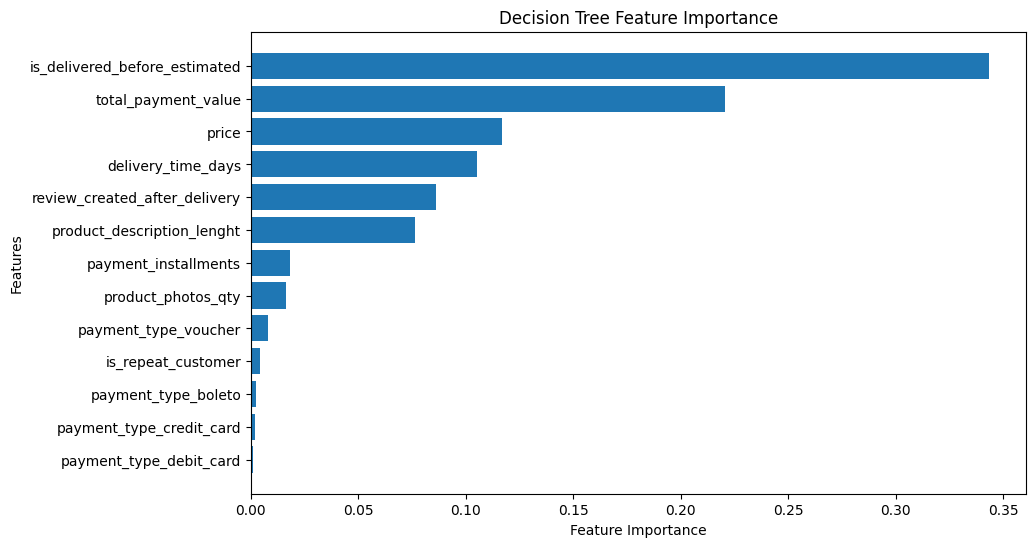

In [43]:
# Feature Importance (Random Search)
dt_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': decision_tree_rs.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Decision Tree Feature Importance:")
print(dt_feature_importance)

# Visualization
plt.figure(figsize=(10, 6))
plt.barh(dt_feature_importance['Feature'], dt_feature_importance['Importance'])
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Decision Tree Feature Importance")
plt.gca().invert_yaxis()
plt.show()

Decision Tree Feature Importance:
                          Feature  Importance
10            total_payment_value    0.254528
0      product_description_lenght    0.195589
3                           price    0.165260
4              delivery_time_days    0.108557
9   is_delivered_before_estimated    0.088416
2            payment_installments    0.065455
1              product_photos_qty    0.048331
12  review_created_after_delivery    0.029785
6             payment_type_boleto    0.013815
5        payment_type_credit_card    0.009839
11             is_repeat_customer    0.009239
7            payment_type_voucher    0.007760
8         payment_type_debit_card    0.003426


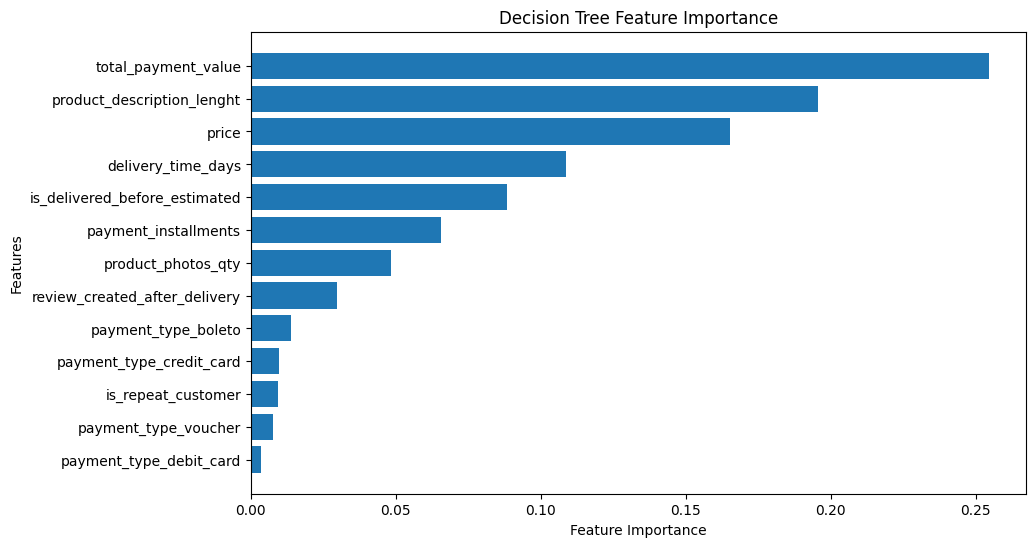

In [44]:
# Feature Importance (without Random Search)
dt_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': decision_tree.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Decision Tree Feature Importance:")
print(dt_feature_importance)

# Visualization
plt.figure(figsize=(10, 6))
plt.barh(dt_feature_importance['Feature'], dt_feature_importance['Importance'])
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Decision Tree Feature Importance")
plt.gca().invert_yaxis()
plt.show()

### Random Forest

In [45]:
# Random Search

# Define hyperparameter space for Random Forest
rf_param_distributions = {
    'n_estimators': [50, 100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# Perform Randomized Search
rf_random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=rf_param_distributions,
    n_iter=20,
    scoring='accuracy',
    cv=5,
    random_state=42,
    verbose=0,
    n_jobs=-1
)

rf_random_search.fit(X_train, y_train)

# Best parameters and model
best_rf_params = rf_random_search.best_params_
rf_model_rs = RandomForestClassifier(random_state=42, **best_rf_params)
rf_model_rs.fit(X_train, y_train)

# Predictions and evaluation
y_pred_rf = rf_model_rs.predict(X_test)

# Evaluate the model performance
print("\n--- Random Forest ---")
print("Accuracy:\n", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



--- Random Forest ---
Accuracy:
 0.8468538615017762
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.43      0.57      4784
           1       0.85      0.97      0.91     15765

    accuracy                           0.85     20549
   macro avg       0.84      0.70      0.74     20549
weighted avg       0.84      0.85      0.83     20549

Confusion Matrix:
 [[ 2070  2714]
 [  433 15332]]


In [46]:
# without Random Search

# Define and train the Random Forest model without Random Search
rf_model = RandomForestClassifier(random_state=42, max_depth=25)

# Train the model
rf_model.fit(X_train, y_train)

# Predictions and evaluation
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model performance
print("\n--- Random Forest ---")
print("Accuracy:\n", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))


--- Random Forest ---
Accuracy:
 0.8477784807046571
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.42      0.56      4784
           1       0.85      0.98      0.91     15765

    accuracy                           0.85     20549
   macro avg       0.85      0.70      0.73     20549
weighted avg       0.85      0.85      0.83     20549

Confusion Matrix:
 [[ 2001  2783]
 [  345 15420]]


In [47]:
# Random Search - Weighted (Train)

# Predict on training data
train_predictions = rf_model_rs.predict(X_train)

# Calculate performance metrics (Weighted)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_train, train_predictions, average='weighted')

# Print the results
print("Model: Random Forest (after Random Search)")
print("Weighted Precision:", precision)
print("Weighted Recall:", recall)
print("Weighted F1-score:", f1_score)


Model: Random Forest (after Random Search)
Weighted Precision: 0.9876468772300333
Weighted Recall: 0.9875051706937246
Weighted F1-score: 0.9873990583237701


In [48]:
# Random Search - Weighted (Test)

# Predict on test data
test_predictions = rf_model_rs.predict(X_test)

# Calculate performance metrics (Weighted)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, test_predictions, average='weighted')

# Print the results
print("Model: Random Forest (after Random Search)")
print("Weighted Precision:", precision)
print("Weighted Recall:", recall)
print("Weighted F1-score:", f1_score)


Model: Random Forest (after Random Search)
Weighted Precision: 0.8443453087331106
Weighted Recall: 0.8468538615017762
Weighted F1-score: 0.8280505831821573


In [49]:
# without Random Search - Weighted (Train)

# Predict on training data
predict = rf_model.predict(X_train)

# Calculate performance metrics (Weighted)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_train, predict, average='weighted')

# Print the result
print("Model: Random Forest")
print("Weighted Precision:", precision)
print("Weighted Recall:", recall)
print("Weighted F1-score:", f1_score)

Model: Random Forest
Weighted Precision: 0.9449207708943226
Weighted Recall: 0.9408229311141932
Weighted F1-score: 0.9377477157171058


In [50]:
# without Random Search - Weighted (Test)

# Predict on training data
predict = rf_model.predict(X_test)

# Calculate performance metrics (Weighted)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, predict, average='weighted')

# Print the result
print("Model: Random Forest")
print("Weighted Precision:", precision)
print("Weighted Recall:", recall)
print("Weighted F1-score:", f1_score)

Model: Random Forest
Weighted Precision: 0.8484699410286335
Weighted Recall: 0.8477784807046571
Weighted F1-score: 0.8272162418473109


In [51]:
# Perform cross-validation (Random Search)
cross_val_scores = cross_val_score(rf_model_rs, X_train, y_train, cv=5, scoring='f1_weighted', n_jobs=-1)

# Print cross-validation results
print("\n--- Cross Validation Results ---")
print("Cross-Validation F1 Macro Scores:", cross_val_scores)
print("Mean F1 Macro Score:", np.mean(cross_val_scores))


--- Cross Validation Results ---
Cross-Validation F1 Macro Scores: [0.81954666 0.82413371 0.82021125 0.81982371 0.8180332 ]
Mean F1 Macro Score: 0.8203497078566672


In [52]:
# Perform cross-validation (without Random Search)
cross_val_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='f1_weighted', n_jobs=-1)

# Print cross-validation results
print("\n--- Cross Validation Results ---")
print("Cross-Validation F1 Macro Scores:", cross_val_scores)
print("Mean F1 Macro Score:", np.mean(cross_val_scores))


--- Cross Validation Results ---
Cross-Validation F1 Macro Scores: [0.82013457 0.82438731 0.82147451 0.8196442  0.81960799]
Mean F1 Macro Score: 0.8210497149207303


Random Forest Feature Importance:
                          Feature  Importance
10            total_payment_value    0.241348
3                           price    0.185151
0      product_description_lenght    0.184380
4              delivery_time_days    0.163327
9   is_delivered_before_estimated    0.067543
12  review_created_after_delivery    0.047909
2            payment_installments    0.046942
1              product_photos_qty    0.041202
11             is_repeat_customer    0.007448
6             payment_type_boleto    0.004885
5        payment_type_credit_card    0.004745
7            payment_type_voucher    0.003720
8         payment_type_debit_card    0.001400


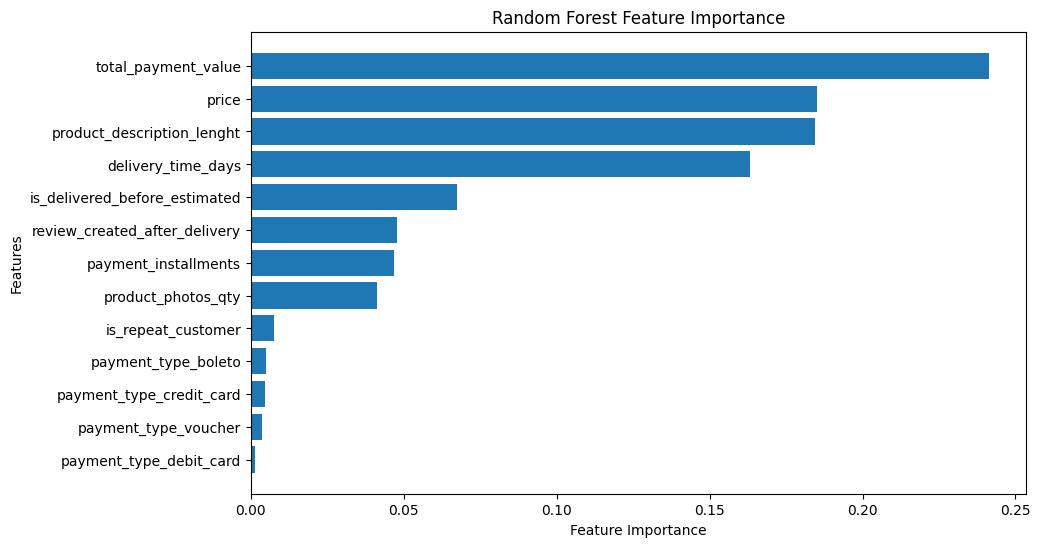

In [53]:
# Random Search

# Feature Importance
rf_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model_rs.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Random Forest Feature Importance:")
print(rf_feature_importance)

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(rf_feature_importance['Feature'], rf_feature_importance['Importance'])
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Random Forest Feature Importance")
plt.gca().invert_yaxis()
plt.show()


Random Forest Feature Importance:
                          Feature  Importance
10            total_payment_value    0.233426
3                           price    0.182678
0      product_description_lenght    0.181925
4              delivery_time_days    0.171438
9   is_delivered_before_estimated    0.061847
2            payment_installments    0.049810
1              product_photos_qty    0.048738
12  review_created_after_delivery    0.042522
11             is_repeat_customer    0.009359
6             payment_type_boleto    0.005914
5        payment_type_credit_card    0.005800
7            payment_type_voucher    0.004385
8         payment_type_debit_card    0.002158


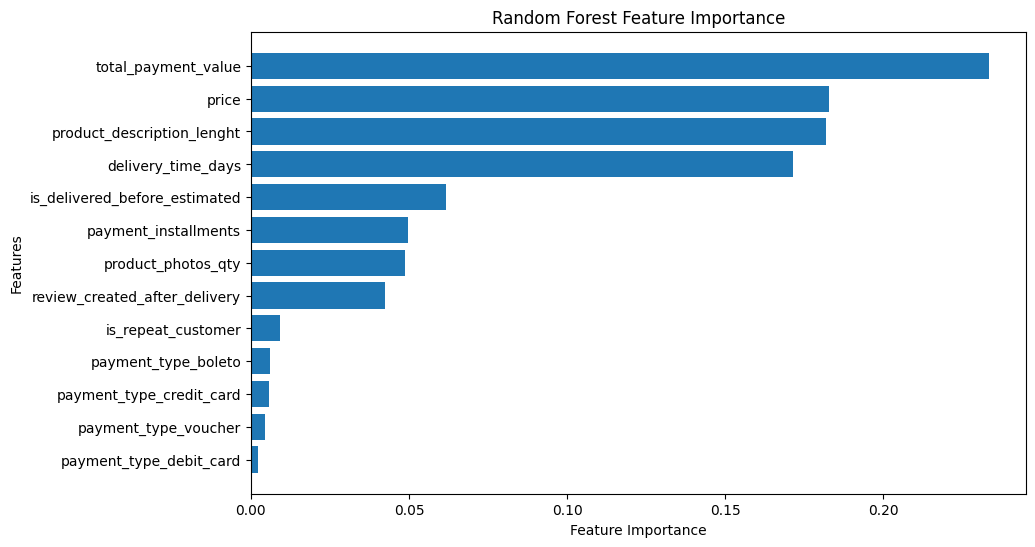

In [54]:
# without Random Search

# Feature Importance
rf_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Random Forest Feature Importance:")
print(rf_feature_importance)

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(rf_feature_importance['Feature'], rf_feature_importance['Importance'])
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Random Forest Feature Importance")
plt.gca().invert_yaxis()
plt.show()


### XGBoost

In [55]:
# Random Search

# Define hyperparameter space for XGBoost
xgb_param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7, 8, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'scale_pos_weight': [1, 10, 50, 100]
}

# Perform Randomized Search
xgb_random_search = RandomizedSearchCV(
    estimator=XGBClassifier(random_state=42),
    param_distributions=xgb_param_distributions,
    n_iter=50,
    scoring='f1',
    cv=3,
    random_state=42,
    verbose=0,
    n_jobs=-1
)

xgb_random_search.fit(X_train, y_train)

# Best parameters and model
best_xgb_params = xgb_random_search.best_params_
xgb_model_rs = XGBClassifier(random_state=42, **best_xgb_params)
xgb_model_rs.fit(X_train, y_train)

# Predictions and evaluation
y_pred_xgb = xgb_model_rs.predict(X_test)

# Evaluate the model performance
print("\n--- XGBoost ---")
print("Accuracy:\n", accuracy_score(y_test, y_pred_xgb))
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))



--- XGBoost ---
Accuracy:
 0.8306000291985012
Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.38      0.51      4784
           1       0.84      0.97      0.90     15765

    accuracy                           0.83     20549
   macro avg       0.81      0.67      0.70     20549
weighted avg       0.82      0.83      0.81     20549

Confusion Matrix:
 [[ 1829  2955]
 [  526 15239]]


In [56]:
# without Random Search

# Create an XGBoost model with basic random seed
xgb_model = XGBClassifier(random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Predict the test set
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model performance
print("\n--- XGBoost ---")
print("Accuracy:\n", accuracy_score(y_test, y_pred_xgb))
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))



--- XGBoost ---
Accuracy:
 0.8150274952552435
Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.29      0.42      4784
           1       0.82      0.97      0.89     15765

    accuracy                           0.82     20549
   macro avg       0.80      0.63      0.66     20549
weighted avg       0.81      0.82      0.78     20549

Confusion Matrix:
 [[ 1389  3395]
 [  406 15359]]


In [57]:
# Random Search - Weighted (Train)

# Predict on training data
train_predictions = xgb_model_rs.predict(X_train)

# Calculate performance metrics (Weighted)
precision, recall, f1_score, _ = precision_recall_fscore_support( y_train, train_predictions, average='weighted')

# Print the results
print("Model: XGBoost (after Random Search)")
print("Weighted Precision:", precision)
print("Weighted Recall:", recall)
print("Weighted F1-score:", f1_score)

Model: XGBoost (after Random Search)
Weighted Precision: 0.8992909344941488
Weighted Recall: 0.891464097136044
Weighted F1-score: 0.8806773364750257


In [58]:
# Random Search - Weighted (Test)

# Predict on training data
train_predictions = xgb_model_rs.predict(X_test)

# Calculate performance metrics (Weighted)
precision, recall, f1_score, _ = precision_recall_fscore_support( y_test, train_predictions, average='weighted')

# Print the results
print("Model: XGBoost (after Random Search)")
print("Weighted Precision:", precision)
print("Weighted Recall:", recall)
print("Weighted F1-score:", f1_score)

Model: XGBoost (after Random Search)
Weighted Precision: 0.8233967913885039
Weighted Recall: 0.8306000291985012
Weighted F1-score: 0.8078397623863093


In [59]:
# without Random Search - Weighted (Train)

# Predict on training data
predict = xgb_model.predict(X_train)

# Calculate performance metrics (Weighted)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_train, predict, average='weighted')

# Print the result
print("Model: XGBoost")
print("Weighted Precision:", precision)
print("Weighted Recall:", recall)
print("Weighted F1-score:", f1_score)

Model: XGBoost
Weighted Precision: 0.8376380874579125
Weighted Recall: 0.8311920578144391
Weighted F1-score: 0.801286968633062


In [60]:
# without Random Search - Weighted (Test)

# Predict on training data
predict = xgb_model.predict(X_test)

# Calculate performance metrics (Weighted)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, predict, average='weighted')

# Print the result
print("Model: XGBoost")
print("Weighted Precision:", precision)
print("Weighted Recall:", recall)
print("Weighted F1-score:", f1_score)

Model: XGBoost
Weighted Precision: 0.8084592595152827
Weighted Recall: 0.8150274952552435
Weighted F1-score: 0.7810171213677434


In [61]:
# Perform cross-validation (Random Search)
cross_val_scores = cross_val_score(xgb_model_rs, X_train, y_train, cv=5, scoring='f1_weighted', n_jobs=-1)

# Print cross-validation results
print("\n--- Cross Validation Results ---")
print("Cross-Validation F1 Macro Scores:", cross_val_scores)
print("Mean F1 Macro Score:", np.mean(cross_val_scores))


--- Cross Validation Results ---
Cross-Validation F1 Macro Scores: [0.80464662 0.80837373 0.8048399  0.80730507 0.80284476]
Mean F1 Macro Score: 0.8056020142399992


In [62]:
# Perform cross-validation (without Random Search)
cross_val_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='f1_weighted', n_jobs=-1)

# Print cross-validation results
print("\n--- Cross Validation Results ---")
print("Cross-Validation F1 Macro Scores:", cross_val_scores)
print("Mean F1 Macro Score:", np.mean(cross_val_scores))


--- Cross Validation Results ---
Cross-Validation F1 Macro Scores: [0.78038761 0.78414224 0.78067234 0.78112588 0.77893345]
Mean F1 Macro Score: 0.7810523047036887


XGBoost Feature Importance:
                          Feature  Importance
9   is_delivered_before_estimated    0.476011
12  review_created_after_delivery    0.144636
7            payment_type_voucher    0.045801
10            total_payment_value    0.041882
3                           price    0.038232
4              delivery_time_days    0.037914
8         payment_type_debit_card    0.037409
0      product_description_lenght    0.033455
11             is_repeat_customer    0.032840
6             payment_type_boleto    0.028962
2            payment_installments    0.028431
1              product_photos_qty    0.027995
5        payment_type_credit_card    0.026433


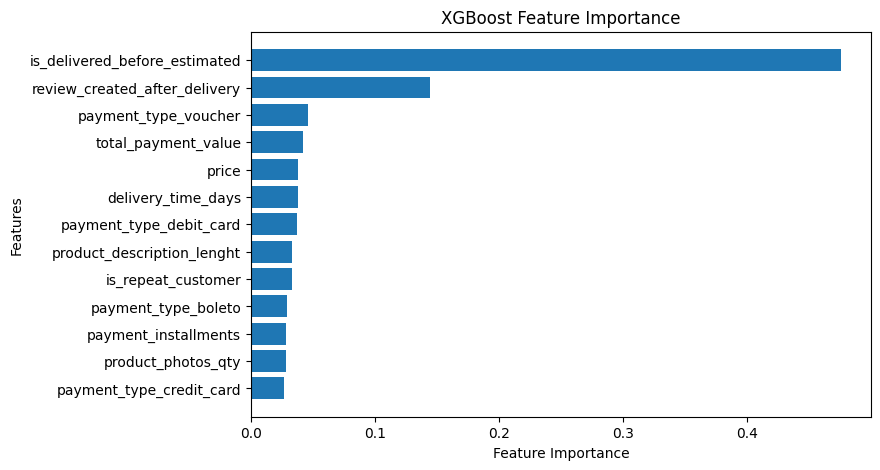

In [63]:
# Feature Importance (Random Search)
xgb_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_model_rs.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("XGBoost Feature Importance:")
print(xgb_feature_importance)

# Visualization
plt.figure(figsize=(8, 5))
plt.barh(xgb_feature_importance['Feature'], xgb_feature_importance['Importance'])
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("XGBoost Feature Importance")
plt.gca().invert_yaxis()
plt.show()


XGBoost Feature Importance:
                          Feature  Importance
9   is_delivered_before_estimated    0.757026
12  review_created_after_delivery    0.137711
10            total_payment_value    0.014877
7            payment_type_voucher    0.012566
3                           price    0.012022
4              delivery_time_days    0.011727
8         payment_type_debit_card    0.010260
6             payment_type_boleto    0.008772
0      product_description_lenght    0.008335
2            payment_installments    0.007144
1              product_photos_qty    0.006792
11             is_repeat_customer    0.006662
5        payment_type_credit_card    0.006105


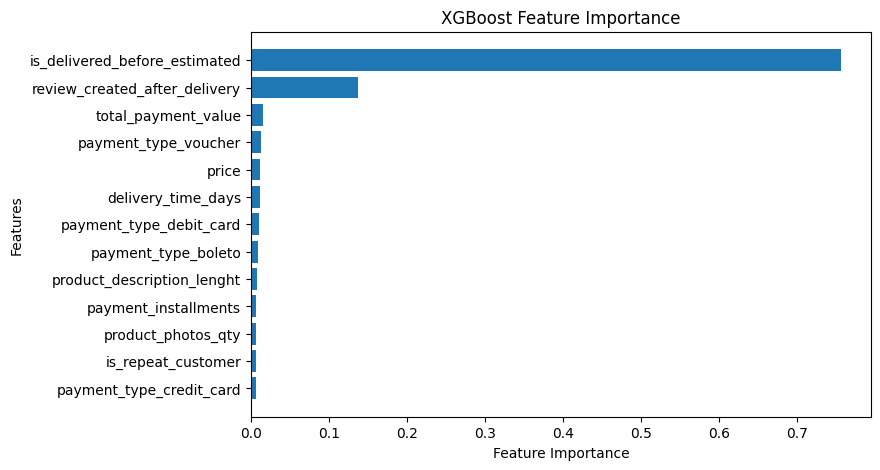

In [64]:
# Feature Importance (without Random Search)
xgb_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("XGBoost Feature Importance:")
print(xgb_feature_importance)

# Visualization
plt.figure(figsize=(8, 5))
plt.barh(xgb_feature_importance['Feature'], xgb_feature_importance['Importance'])
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("XGBoost Feature Importance")
plt.gca().invert_yaxis()
plt.show()


## 6Var Model

### Preparation for model

In [65]:
# Prepare the data
features_list = ['price', 'product_description_lenght', 'product_photos_qty', 
                 'delivery_time_days', 'is_delivered_before_estimated', 'total_payment_value']

# Extract features from 'df'
X = df[features_list]
y = df['positive_review']       # Target variable

# Split the dataset into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Logistic Regression

In [66]:
# Random Search

# Hyperparameter range for Randomized Search
param_distributions = {
    'penalty': ['l1', 'l2', 'elasticnet', None],
    'C': np.logspace(-4, 4, 20),
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 200, 500]
}

# Randomized Search for hyperparameter tuning of the Logistic Regression model
random_search_logR = RandomizedSearchCV(
    estimator=LogisticRegression(random_state=42),
    param_distributions=param_distributions,
    n_iter=20,
    scoring='accuracy',
    cv=5,
    random_state=42,
    verbose=0,
    n_jobs=-1
)

# Execute Randomized Search
random_search_logR.fit(X_train, y_train)

# Use the best model for prediction and evaluation
best_LogR_params = random_search_logR.best_params_
LogR_model_rs = LogisticRegression(random_state=42, **best_LogR_params)
LogR_model_rs.fit(X_train, y_train)

# Predictions and evaluation
logR_y_pred = LogR_model_rs.predict(X_test)

# Evaluate the model performance
print("\n--- Logistic Regression ---")
print("Accuracy:\n", accuracy_score(y_test, logR_y_pred))
print("Classification Report:\n", classification_report(y_test, logR_y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, logR_y_pred))

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1208: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:349: ConvergenceWarning: The max_iter


--- Logistic Regression ---
Accuracy:
 0.7930799552289649
Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.20      0.31      4784
           1       0.80      0.97      0.88     15765

    accuracy                           0.79     20549
   macro avg       0.75      0.59      0.60     20549
weighted avg       0.77      0.79      0.75     20549

Confusion Matrix:
 [[  967  3817]
 [  435 15330]]


In [67]:
# without Random Search

# Create an XGBoost model with basic random seed
LogR_model = LogisticRegression(random_state=42)

# Train the model
LogR_model.fit(X_train, y_train)

# Predict the test set
logR_y_pred = LogR_model.predict(X_test)

# Display evaluation results
print("logR Accuracy:\n", accuracy_score(y_test, logR_y_pred))
print("\nlogR Confusion Matrix:\n", confusion_matrix(y_test, logR_y_pred))
print("\nlogR Classification Report:\n", classification_report(y_test, logR_y_pred))

logR Accuracy:
 0.7931286193975375

logR Confusion Matrix:
 [[  972  3812]
 [  439 15326]]

logR Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.20      0.31      4784
           1       0.80      0.97      0.88     15765

    accuracy                           0.79     20549
   macro avg       0.74      0.59      0.60     20549
weighted avg       0.77      0.79      0.75     20549



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [68]:
# Random Search - Weighted (Train)

# Predict on training data
train_predictions = LogR_model_rs.predict(X_train)

# Calculate performance metrics (Weighted)
precision, recall, f1_score, _ = precision_recall_fscore_support( y_train, train_predictions, average='weighted')

# Print the results
print("Model: Logistic Regression (after Random Search)")
print("Weighted Precision:", precision)
print("Weighted Recall:", recall)
print("Weighted F1-score:", f1_score)

Model: Logistic Regression (after Random Search)
Weighted Precision: 0.7780134054163929
Weighted Recall: 0.7935494074993309
Weighted F1-score: 0.7497624690788798


In [69]:
# Random Search - Weighted (Test)

# Predict on training data
train_predictions = LogR_model_rs.predict(X_test)

# Calculate performance metrics (Weighted)
precision, recall, f1_score, _ = precision_recall_fscore_support( y_test, train_predictions, average='weighted')

# Print the results
print("Model: Logistic Regression (after Random Search)")
print("Weighted Precision:", precision)
print("Weighted Recall:", recall)
print("Weighted F1-score:", f1_score)

Model: Logistic Regression (after Random Search)
Weighted Precision: 0.7748247157399633
Weighted Recall: 0.7930799552289649
Weighted F1-score: 0.7465388510244643


In [70]:
# without Random Search - Weighted (Train)

# Predict on training data
predict = LogR_model.predict(X_train)

# Calculate performance metrics (Weighted)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_train, predict, average='weighted')

# Print the sesults
print("Model: Logistic Model")
print("Weighted Precision:", precision)
print("Weighted Recall:", recall)
print("Weighted F1-score:", f1_score)

Model: Logistic Model
Weighted Precision: 0.7777137394018135
Weighted Recall: 0.7935007421466287
Weighted F1-score: 0.7499319486098294


In [71]:
# without Random Search - Weighted (Test)

# Predict on training data
predict = LogR_model.predict(X_test)

# Calculate performance metrics (Weighted)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, predict, average='weighted')

# Print the sesults
print("Model: Logistic Model")
print("Weighted Precision:", precision)
print("Weighted Recall:", recall)
print("Weighted F1-score:", f1_score)

Model: Logistic Model
Weighted Precision: 0.7747539860346593
Weighted Recall: 0.7931286193975375
Weighted F1-score: 0.7468067979785832


In [72]:
# Perform cross-validation (Random Search)
scores = cross_val_score(LogR_model_rs, X_train, y_train, cv=5, scoring='f1_macro', n_jobs=-1)

# Print cross-validation results
print("\n--- Cross Validation Results ---")
print("Cross-Validation F1-scores:", scores)
print("Mean F1-score:", np.mean(scores))


--- Cross Validation Results ---
Cross-Validation F1-scores: [0.61004431 0.61014619 0.61224624 0.60926396 0.60450278]
Mean F1-score: 0.6092406937464148


In [73]:
# Perform cross-validation (without Random Search)
scores = cross_val_score(LogR_model, X_train, y_train, cv=5, scoring='f1_macro', n_jobs=-1)

# Print cross-validation results
print("\n--- Cross Validation Results ---")
print("Cross-Validation F1-scores:", scores)
print("Mean F1-score:", np.mean(scores))


--- Cross Validation Results ---
Cross-Validation F1-scores: [0.61131623 0.61516458 0.61213887 0.60926396 0.60690837]
Mean F1-score: 0.6109584017261349


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

In [74]:
# Feature Importance (Random Search)
LogR_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': np.abs(LogR_model_rs.coef_[0])
}).sort_values(by='Importance', ascending=False)

print("Logistic Regression Feature Importance")
print(LogR_feature_importance)

Logistic Regression Feature Importance
                         Feature  Importance
4  is_delivered_before_estimated    1.090261
3             delivery_time_days    0.048288
2             product_photos_qty    0.009107
0                          price    0.000624
5            total_payment_value    0.000262
1     product_description_lenght    0.000070


In [75]:
# Feature Importance (without Random Search)
LogR_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': np.abs(LogR_model.coef_[0])
}).sort_values(by='Importance', ascending=False)

print("Logistic Regression Feature Importance")
print(LogR_feature_importance)

Logistic Regression Feature Importance
                         Feature  Importance
4  is_delivered_before_estimated    1.117465
3             delivery_time_days    0.048330
2             product_photos_qty    0.010020
0                          price    0.000637
5            total_payment_value    0.000261
1     product_description_lenght    0.000043


### Decision Tree

In [76]:
# Random Search

# Define hyperparameter space for Random Forest
param_distributions = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None] + list(range(2, 20)),
    'min_samples_split': range(2, 10),
    'min_samples_leaf': range(1, 10),
    'max_features': [None, 'sqrt', 'log2']
}

# Perform Randomized Search
dt_random_search = RandomizedSearchCV(
    estimator=DecisionTreeClassifier(random_state=42), 
    param_distributions=param_distributions, 
    n_iter=50,
    scoring='accuracy',
    cv=5,
    random_state=42,
    verbose=0,
    n_jobs=-1
)

dt_random_search.fit(X_train, y_train)

# Best parameters and model
decision_tree_rs = dt_random_search.best_estimator_

# Predictions and evaluation
y_pred_dt = decision_tree_rs.predict(X_test)

# Evaluate the model performance
print("\n--- Decision Tree with Random Search ---")
print("Accuracy:\n", accuracy_score(y_test, y_pred_dt))
print("Classification Report:\n", classification_report(y_test, y_pred_dt))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))



--- Decision Tree with Random Search ---
Accuracy:
 0.7940532386004185
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.23      0.34      4784
           1       0.80      0.97      0.88     15765

    accuracy                           0.79     20549
   macro avg       0.74      0.60      0.61     20549
weighted avg       0.77      0.79      0.75     20549

Confusion Matrix:
 [[ 1082  3702]
 [  530 15235]]


In [77]:
# without Random Search

# Create an Decision Tree model with basic random seed
decision_tree = DecisionTreeClassifier(random_state=42)

# Train the model
decision_tree.fit(X_train, y_train)

# Predict the test set
y_pred_dt = decision_tree.predict(X_test)

# Evaluate the model performance
print("\n--- Decision Tree ---")
print("Accuracy:\n", accuracy_score(y_test, y_pred_dt))
print("Classification Report:\n", classification_report(y_test, y_pred_dt))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))


--- Decision Tree ---
Accuracy:
 0.7689425276169156
Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.54      0.52      4784
           1       0.86      0.84      0.85     15765

    accuracy                           0.77     20549
   macro avg       0.68      0.69      0.69     20549
weighted avg       0.78      0.77      0.77     20549

Confusion Matrix:
 [[ 2604  2180]
 [ 2568 13197]]


In [78]:
# Random Search - Weighted (Train)

# Predict on training data
train_predictions = decision_tree_rs.predict(X_train)

# Calculate performance metrics (Weighted)
precision, recall, f1_score, _ = precision_recall_fscore_support( y_train, train_predictions, average='weighted')

# Print the results
print("Model: Decision Tree (after Random Search)")
print("Weighted Precision:", precision)
print("Weighted Recall:", recall)
print("Weighted F1-score:", f1_score)

Model: Decision Tree (after Random Search)
Weighted Precision: 0.8072418107505629
Weighted Recall: 0.8107769423558897
Weighted F1-score: 0.7737695829235867


In [79]:
# Random Search - Weighted (Test)

# Predict on training data
train_predictions = decision_tree_rs.predict(X_test)

# Calculate performance metrics (Weighted)
precision, recall, f1_score, _ = precision_recall_fscore_support( y_test, train_predictions, average='weighted')

# Print the results
print("Model: Decision Tree (after Random Search)")
print("Weighted Precision:", precision)
print("Weighted Recall:", recall)
print("Weighted F1-score:", f1_score)

Model: Decision Tree (after Random Search)
Weighted Precision: 0.7734776406362753
Weighted Recall: 0.7940532386004185
Weighted F1-score: 0.7523976100830994


In [80]:
# without Random Search - Weighted (Train)

# Predict on training data
predict = decision_tree.predict(X_train)

# Calculate performance metrics (Weighted)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_train, predict, average='weighted')

# Print the result
print("Model: decision_tree")
print("Weighted Precision:", precision)
print("Weighted Recall:", recall)
print("Weighted F1-score:", f1_score)

Model: decision_tree
Weighted Precision: 0.990458045990211
Weighted Recall: 0.990327761150449
Weighted F1-score: 0.9903613264009098


In [81]:
# without Random Search - Weighted (Test)

# Predict on training data
predict = decision_tree.predict(X_test)

# Calculate performance metrics (Weighted)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, predict, average='weighted')

# Print the result
print("Model: decision_tree")
print("Weighted Precision:", precision)
print("Weighted Recall:", recall)
print("Weighted F1-score:", f1_score)

Model: decision_tree
Weighted Precision: 0.7756408011870217
Weighted Recall: 0.7689425276169156
Weighted F1-score: 0.7720054735286483


In [82]:
# Perform cross-validation (Random Search)
cross_val_scores = cross_val_score(decision_tree_rs, X_train, y_train, cv=5, scoring='f1_macro', n_jobs=-1)

# Print cross-validation results
print("\n--- Cross Validation Results ---")
print("Cross-Validation F1 Macro Scores:", cross_val_scores)
print("Mean F1 Macro Score:", np.mean(cross_val_scores))


--- Cross Validation Results ---
Cross-Validation F1 Macro Scores: [0.62567973 0.64140315 0.63563421 0.62618317 0.62106699]
Mean F1 Macro Score: 0.629993450180185


In [83]:
# Perform cross-validation (without Random Search)
cross_val_scores = cross_val_score(decision_tree, X_train, y_train, cv=5, scoring='f1_macro', n_jobs=-1)

# Print cross-validation results
print("\n--- Cross Validation Results ---")
print("Cross-Validation F1 Macro Scores:", cross_val_scores)
print("Mean F1 Macro Score:", np.mean(cross_val_scores))


--- Cross Validation Results ---
Cross-Validation F1 Macro Scores: [0.66375312 0.67631455 0.67201749 0.67516335 0.66767897]
Mean F1 Macro Score: 0.6709854965777846


Decision Tree Feature Importance:
                         Feature  Importance
4  is_delivered_before_estimated    0.360062
5            total_payment_value    0.233590
3             delivery_time_days    0.151052
0                          price    0.142149
1     product_description_lenght    0.094925
2             product_photos_qty    0.018223


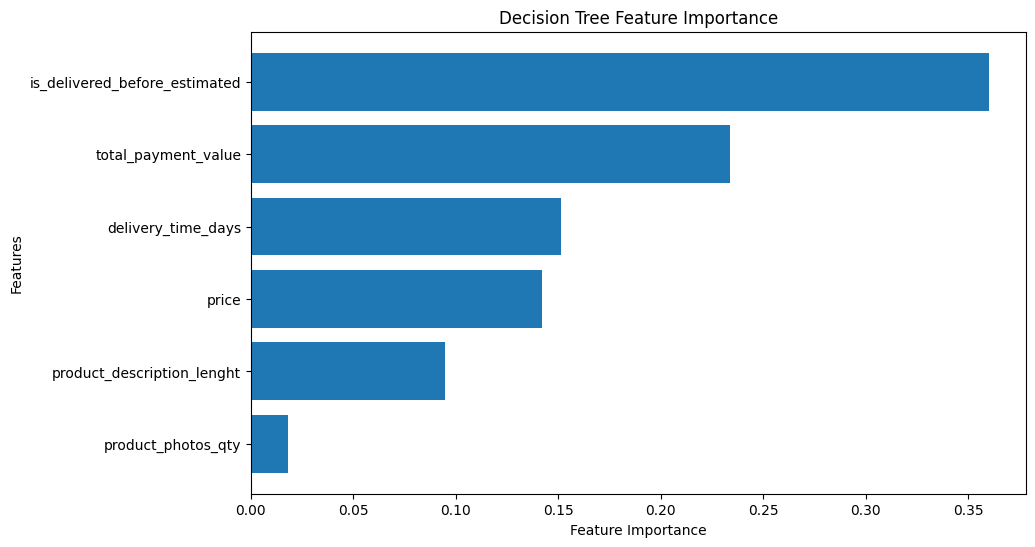

In [84]:
# Feature Importance (Random Search)
dt_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': decision_tree_rs.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Decision Tree Feature Importance:")
print(dt_feature_importance)

# Visualization
plt.figure(figsize=(10, 6))
plt.barh(dt_feature_importance['Feature'], dt_feature_importance['Importance'])
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Decision Tree Feature Importance")
plt.gca().invert_yaxis()
plt.show()

Decision Tree Feature Importance:
                         Feature  Importance
5            total_payment_value    0.302564
1     product_description_lenght    0.234426
0                          price    0.179688
3             delivery_time_days    0.137531
4  is_delivered_before_estimated    0.090402
2             product_photos_qty    0.055390


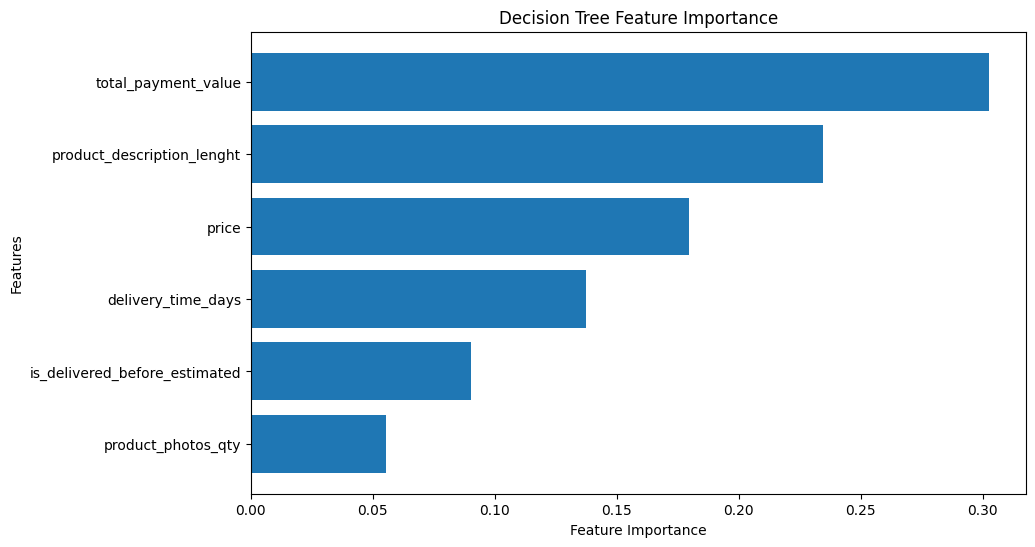

In [85]:
# Feature Importance (without Random Search)
dt_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': decision_tree.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Decision Tree Feature Importance:")
print(dt_feature_importance)

# Visualization
plt.figure(figsize=(10, 6))
plt.barh(dt_feature_importance['Feature'], dt_feature_importance['Importance'])
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Decision Tree Feature Importance")
plt.gca().invert_yaxis()
plt.show()

### Random Forest

In [86]:
# Random Search

# Define hyperparameter space for Random Forest
rf_param_distributions = {
    'n_estimators': [50, 100, 200, 300, 400, 500],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

# Perform Randomized Search
rf_random_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=rf_param_distributions,
    n_iter=20,
    scoring='accuracy',
    cv=5,
    random_state=42,
    verbose=0,
    n_jobs=-1
)

rf_random_search.fit(X_train, y_train)

# Best parameters and model
best_rf_params = rf_random_search.best_params_
rf_model_rs = RandomForestClassifier(random_state=42, **best_rf_params)
rf_model_rs.fit(X_train, y_train)

# Predictions and evaluation
y_pred_rf = rf_model_rs.predict(X_test)

# Evaluate the model performance
print("\n--- Random Forest ---")
print("Accuracy:\n", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



--- Random Forest ---
Accuracy:
 0.8388242736872841
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.42      0.55      4784
           1       0.85      0.97      0.90     15765

    accuracy                           0.84     20549
   macro avg       0.82      0.69      0.72     20549
weighted avg       0.83      0.84      0.82     20549

Confusion Matrix:
 [[ 1998  2786]
 [  526 15239]]


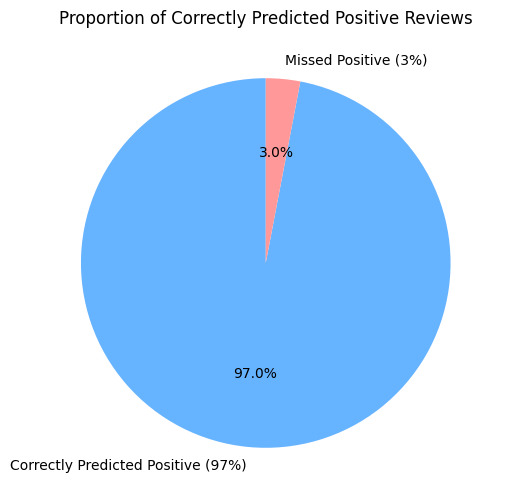

In [87]:
import matplotlib.pyplot as plt

# Data for visualization
labels = ['Correctly Predicted Positive (97%)', 'Missed Positive (3%)']
sizes = [97, 3]  # Based on recall of 0.97 for Class 1
colors = ['#66b3ff', '#ff9999']

# Plot the pie chart
plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Proportion of Correctly Predicted Positive Reviews')
plt.show()


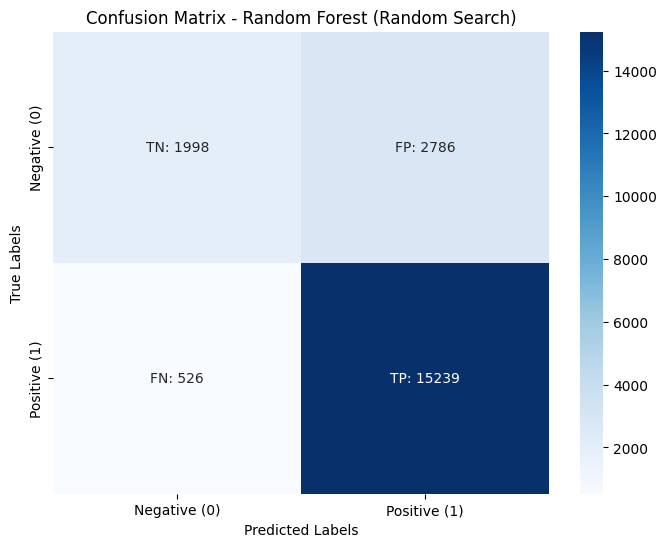

In [88]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred_rf)

# Define labels for the confusion matrix cells
labels = [
    f"TN: {cm[0, 0]}",  # True Negatives
    f"FP: {cm[0, 1]}",  # False Positives
    f"FN: {cm[1, 0]}",  # False Negatives
    f"TP: {cm[1, 1]}"   # True Positives
]
labels = np.array(labels).reshape(2, 2)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', xticklabels=['Negative (0)', 'Positive (1)'], yticklabels=['Negative (0)', 'Positive (1)'])
plt.title('Confusion Matrix - Random Forest (Random Search)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [89]:
# without Random Search

# Define and train the Random Forest model without Random Search
rf_model = RandomForestClassifier(random_state=42, max_depth=25)

rf_model.fit(X_train, y_train)

# Predictions and evaluation
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model performance
print("\n--- Random Forest ---")
print("Accuracy:\n", accuracy_score(y_test, y_pred_rf))
print("Classification Report:\n", classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))


--- Random Forest ---
Accuracy:
 0.8432040488588253
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.44      0.56      4784
           1       0.85      0.97      0.90     15765

    accuracy                           0.84     20549
   macro avg       0.82      0.70      0.73     20549
weighted avg       0.84      0.84      0.83     20549

Confusion Matrix:
 [[ 2087  2697]
 [  525 15240]]


In [90]:
# Random Search - Weighted (Train)

# Predict on training data
train_predictions = rf_model_rs.predict(X_train)

# Calculate performance metrics (Weighted)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_train, train_predictions, average='weighted')

# Print the results
print("Model: Random Forest (after Random Search)")
print("Weighted Precision:", precision)
print("Weighted Recall:", recall)
print("Weighted F1-score:", f1_score)


Model: Random Forest (after Random Search)
Weighted Precision: 0.92782600408692
Weighted Recall: 0.9238022240066185
Weighted F1-score: 0.9191200596947047


In [91]:
# Random Search - Weighted (Test)

# Predict on test data
test_predictions = rf_model_rs.predict(X_test)

# Calculate performance metrics (Weighted)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, test_predictions, average='weighted')

# Print the results
print("Model: Random Forest (after Random Search)")
print("Weighted Precision:", precision)
print("Weighted Recall:", recall)
print("Weighted F1-score:", f1_score)


Model: Random Forest (after Random Search)
Weighted Precision: 0.8329033069251943
Weighted Recall: 0.8388242736872841
Weighted F1-score: 0.8192924799099763


In [92]:
# without Random Search - Weighted (Train)

# Predict on training data
predict = rf_model.predict(X_train)

# Calculate performance metrics (Weighted)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_train, predict, average='weighted')

# Print the result
print("Model: Random Forest")
print("Weighted Precision:", precision)
print("Weighted Recall:", recall)
print("Weighted F1-score:", f1_score)

Model: Random Forest
Weighted Precision: 0.9482744333697948
Weighted Recall: 0.9448986544029978
Weighted F1-score: 0.9423165358754882


In [93]:
# without Random Search - Weighted (Test)

# Predict on training data
predict = rf_model.predict(X_test)

# Calculate performance metrics (Weighted)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, predict, average='weighted')

# Print the result
print("Model: Random Forest")
print("Weighted Precision:", precision)
print("Weighted Recall:", recall)
print("Weighted F1-score:", f1_score)

Model: Random Forest
Weighted Precision: 0.837851915527673
Weighted Recall: 0.8432040488588253
Weighted F1-score: 0.8252332696584407


In [94]:
# Perform cross-validation (Random Search)
cross_val_scores = cross_val_score(rf_model_rs, X_train, y_train, cv=5, scoring='f1_weighted', n_jobs=-1)

# Print cross-validation results
print("\n--- Cross Validation Results ---")
print("Cross-Validation F1 Macro Scores:", cross_val_scores)
print("Mean F1 Macro Score:", np.mean(cross_val_scores))


--- Cross Validation Results ---
Cross-Validation F1 Macro Scores: [0.81269562 0.8146804  0.8112694  0.81321132 0.8127349 ]
Mean F1 Macro Score: 0.8129183299936308


In [95]:
# Perform cross-validation (without Random Search)
cross_val_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='f1_weighted', n_jobs=-1)

# Print cross-validation results
print("\n--- Cross Validation Results ---")
print("Cross-Validation F1 Macro Scores:", cross_val_scores)
print("Mean F1 Macro Score:", np.mean(cross_val_scores))


--- Cross Validation Results ---
Cross-Validation F1 Macro Scores: [0.81745707 0.82216    0.81788418 0.81726023 0.81596987]
Mean F1 Macro Score: 0.81814626903803


Random Forest Feature Importance:
                         Feature  Importance
5            total_payment_value    0.275957
1     product_description_lenght    0.196070
0                          price    0.195768
3             delivery_time_days    0.182821
4  is_delivered_before_estimated    0.109983
2             product_photos_qty    0.039402


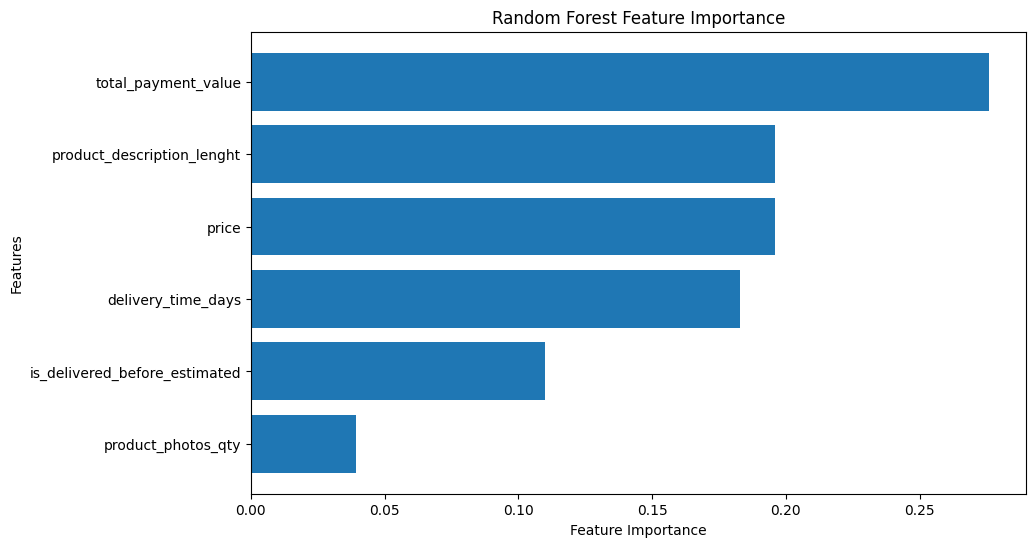

In [96]:
# Random Search
# Feature Importance
rf_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model_rs.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Random Forest Feature Importance:")
print(rf_feature_importance)

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(rf_feature_importance['Feature'], rf_feature_importance['Importance'])
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Random Forest Feature Importance")
plt.gca().invert_yaxis()
plt.show()


In [97]:
# Example: Calculate Pearson Correlation
correlations = X_test.corrwith(y_test)
print(correlations)

price                            0.020642
product_description_lenght       0.016068
product_photos_qty               0.014602
delivery_time_days              -0.259282
is_delivered_before_estimated    0.274203
total_payment_value             -0.094347
dtype: float64


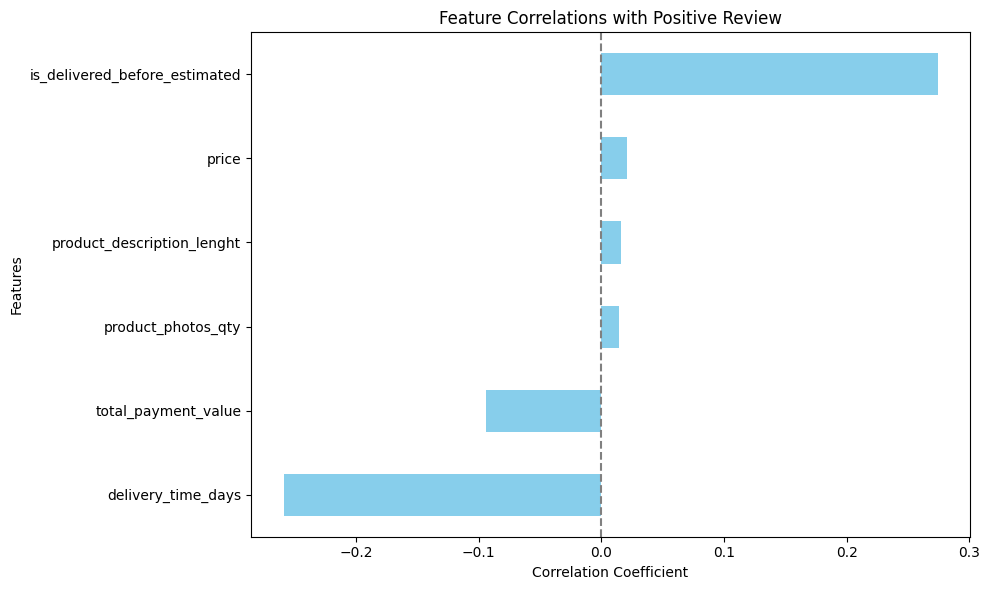

In [98]:
# Assuming `correlations` the correlation coefficients between features and the target variable
correlations = X_test.corrwith(y_test)

# Create a bar chart
plt.figure(figsize=(10, 6))
correlations.sort_values().plot(kind='barh', color='skyblue')
plt.title('Feature Correlations with Positive Review')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.axvline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()


Random Forest Feature Importance:
                         Feature  Importance
5            total_payment_value    0.281513
1     product_description_lenght    0.211948
0                          price    0.202904
3             delivery_time_days    0.181110
4  is_delivered_before_estimated    0.073275
2             product_photos_qty    0.049249


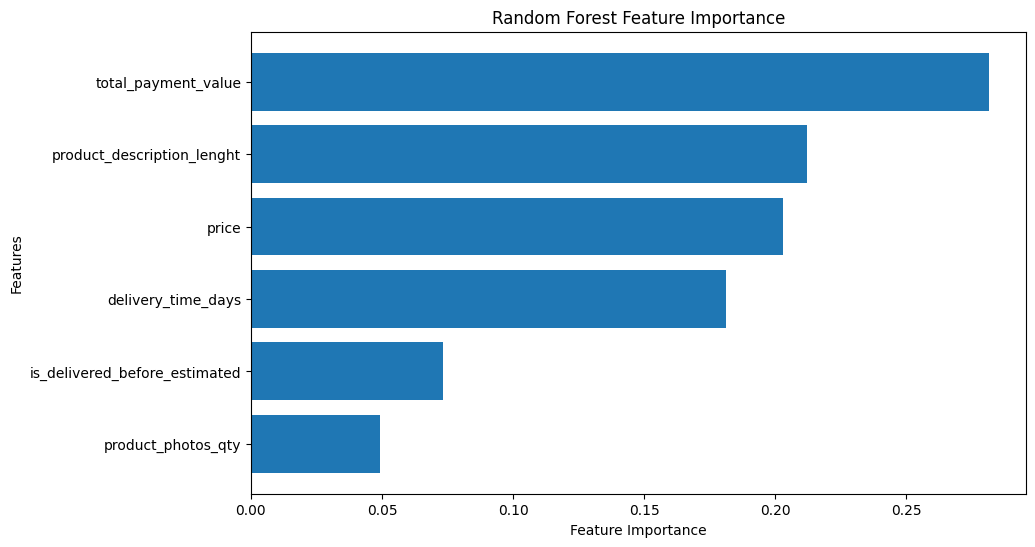

In [99]:
# without Random Search
# Feature Importance
rf_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Random Forest Feature Importance:")
print(rf_feature_importance)

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(rf_feature_importance['Feature'], rf_feature_importance['Importance'])
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Random Forest Feature Importance")
plt.gca().invert_yaxis()
plt.show()


### XGBoost

In [100]:
# Random Search

# Define hyperparameter space for XGBoost
xgb_param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5, 6, 7, 8, 9],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'scale_pos_weight': [1, 10, 50, 100]
}

# Perform Randomized Search
xgb_random_search = RandomizedSearchCV(
    estimator=XGBClassifier(random_state=42),
    param_distributions=xgb_param_distributions,
    n_iter=50,
    scoring='f1',
    cv=3,
    random_state=42,
    verbose=0,
    n_jobs=-1
)

xgb_random_search.fit(X_train, y_train)

# Best parameters and model
best_xgb_params = xgb_random_search.best_params_
xgb_model_rs = XGBClassifier(random_state=42, **best_xgb_params)
xgb_model_rs.fit(X_train, y_train)

# Predictions and evaluation
y_pred_xgb = xgb_model_rs.predict(X_test)

# Evaluate the model performance
print("\n--- XGBoost ---")
print("Accuracy:\n", accuracy_score(y_test, y_pred_xgb))
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))



--- XGBoost ---
Accuracy:
 0.8222297922040002
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.36      0.49      4784
           1       0.83      0.96      0.89     15765

    accuracy                           0.82     20549
   macro avg       0.79      0.66      0.69     20549
weighted avg       0.81      0.82      0.80     20549

Confusion Matrix:
 [[ 1736  3048]
 [  605 15160]]


In [101]:
# without Random Search

# Create an XGBoost model with basic random seed
xgb_model = XGBClassifier(random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Predict the test set
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate the model performance
print("\n--- XGBoost ---")
print("Accuracy:\n", accuracy_score(y_test, y_pred_xgb))
print("Classification Report:\n", classification_report(y_test, y_pred_xgb))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))



--- XGBoost ---
Accuracy:
 0.8088471458465132
Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.27      0.40      4784
           1       0.82      0.97      0.89     15765

    accuracy                           0.81     20549
   macro avg       0.78      0.62      0.64     20549
weighted avg       0.80      0.81      0.77     20549

Confusion Matrix:
 [[ 1312  3472]
 [  456 15309]]


In [102]:
# Random Search - Weighted (Train)

# Predict on training data
train_predictions = xgb_model_rs.predict(X_train)

# Calculate performance metrics (Weighted)
precision, recall, f1_score, _ = precision_recall_fscore_support( y_train, train_predictions, average='weighted')

# Print the results
print("Model: XGBoost (after Random Search)")
print("Weighted Precision:", precision)
print("Weighted Recall:", recall)
print("Weighted F1-score:", f1_score)

Model: XGBoost (after Random Search)
Weighted Precision: 0.8871591972444185
Weighted Recall: 0.8796384164294231
Weighted F1-score: 0.8664029032974517


In [103]:
# Random Search - Weighted (Test)

# Predict on training data
train_predictions = xgb_model_rs.predict(X_test)

# Calculate performance metrics (Weighted)
precision, recall, f1_score, _ = precision_recall_fscore_support( y_test, train_predictions, average='weighted')

# Print the results
print("Model: XGBoost (after Random Search)")
print("Weighted Precision:", precision)
print("Weighted Recall:", recall)
print("Weighted F1-score:", f1_score)

Model: XGBoost (after Random Search)
Weighted Precision: 0.8114066423774108
Weighted Recall: 0.8222297922040002
Weighted F1-score: 0.7981448492104675


In [104]:
# without Random Search - Weighted (Train)
# Predict on training data
predict = xgb_model.predict(X_train)

# Calculate performance metrics (Weighted)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_train, predict, average='weighted')

# Print the result
print("Model: XGBoost")
print("Weighted Precision:", precision)
print("Weighted Recall:", recall)
print("Weighted F1-score:", f1_score)

Model: XGBoost
Weighted Precision: 0.8297011498132665
Weighted Recall: 0.8275543226999538
Weighted F1-score: 0.7979323422008168


In [105]:
# without Random Search - Weighted (Test)
# Predict on training data
predict = xgb_model.predict(X_test)

# Calculate performance metrics (Weighted)
precision, recall, f1_score, _ = precision_recall_fscore_support(y_test, predict, average='weighted')

# Print the result
print("Model: XGBoost")
print("Weighted Precision:", precision)
print("Weighted Recall:", recall)
print("Weighted F1-score:", f1_score)

Model: XGBoost
Weighted Precision: 0.798125387430334
Weighted Recall: 0.8088471458465132
Weighted F1-score: 0.7731958410355346


In [106]:
# Perform cross-validation
cross_val_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='f1_weighted', n_jobs=-1)

# Print cross-validation results
print("\n--- Cross Validation Results ---")
print("Cross-Validation F1 Macro Scores:", cross_val_scores)
print("Mean F1 Macro Score:", np.mean(cross_val_scores))


--- Cross Validation Results ---
Cross-Validation F1 Macro Scores: [0.77579801 0.78055353 0.77459629 0.7754008  0.77662057]
Mean F1 Macro Score: 0.7765938398893281


XGBoost Feature Importance:
                         Feature  Importance
4  is_delivered_before_estimated    0.599042
3             delivery_time_days    0.095018
5            total_payment_value    0.089205
0                          price    0.081534
1     product_description_lenght    0.075807
2             product_photos_qty    0.059394


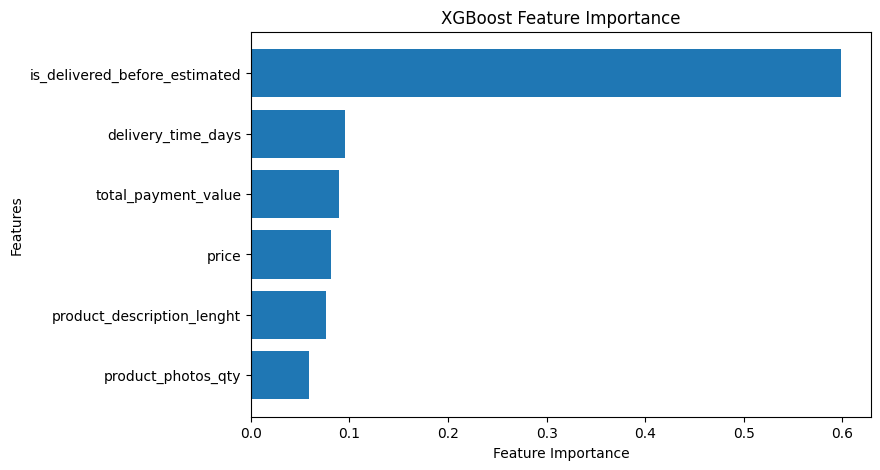

In [107]:
# Feature Importance (Random Search)
xgb_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_model_rs.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("XGBoost Feature Importance:")
print(xgb_feature_importance)

# Visualization
plt.figure(figsize=(8, 5))
plt.barh(xgb_feature_importance['Feature'], xgb_feature_importance['Importance'])
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("XGBoost Feature Importance")
plt.gca().invert_yaxis()
plt.show()


XGBoost Feature Importance:
                         Feature  Importance
4  is_delivered_before_estimated    0.885999
5            total_payment_value    0.029586
3             delivery_time_days    0.029298
0                          price    0.025789
1     product_description_lenght    0.016233
2             product_photos_qty    0.013095


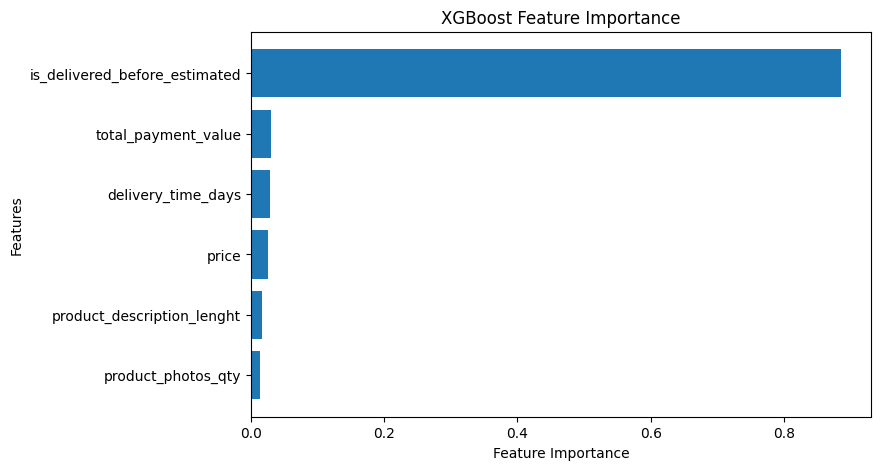

In [108]:
# Feature Importance (without Random Search)
xgb_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("XGBoost Feature Importance:")
print(xgb_feature_importance)

# Visualization
plt.figure(figsize=(8, 5))
plt.barh(xgb_feature_importance['Feature'], xgb_feature_importance['Importance'])
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("XGBoost Feature Importance")
plt.gca().invert_yaxis()
plt.show()


# Conclusion

Random Forest Feature Importance:
                         Feature  Importance
5            total_payment_value    0.275957
1     product_description_lenght    0.196070
0                          price    0.195768
3             delivery_time_days    0.182821
4  is_delivered_before_estimated    0.109983
2             product_photos_qty    0.039402


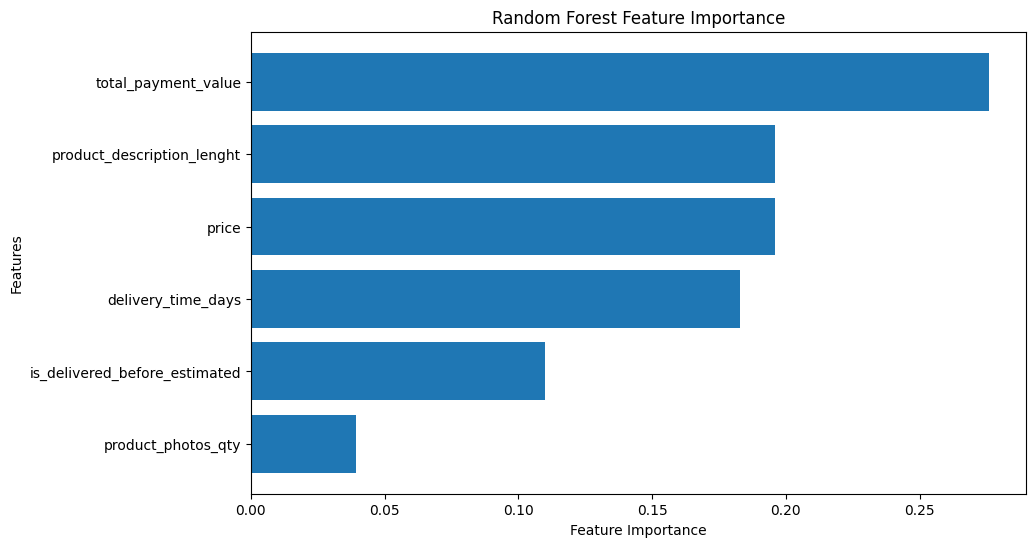

In [109]:
# Random Search
# Feature Importance
rf_feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_model_rs.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Random Forest Feature Importance:")
print(rf_feature_importance)

# Visualize feature importance
plt.figure(figsize=(10, 6))
plt.barh(rf_feature_importance['Feature'], rf_feature_importance['Importance'])
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Random Forest Feature Importance")
plt.gca().invert_yaxis()
plt.show()

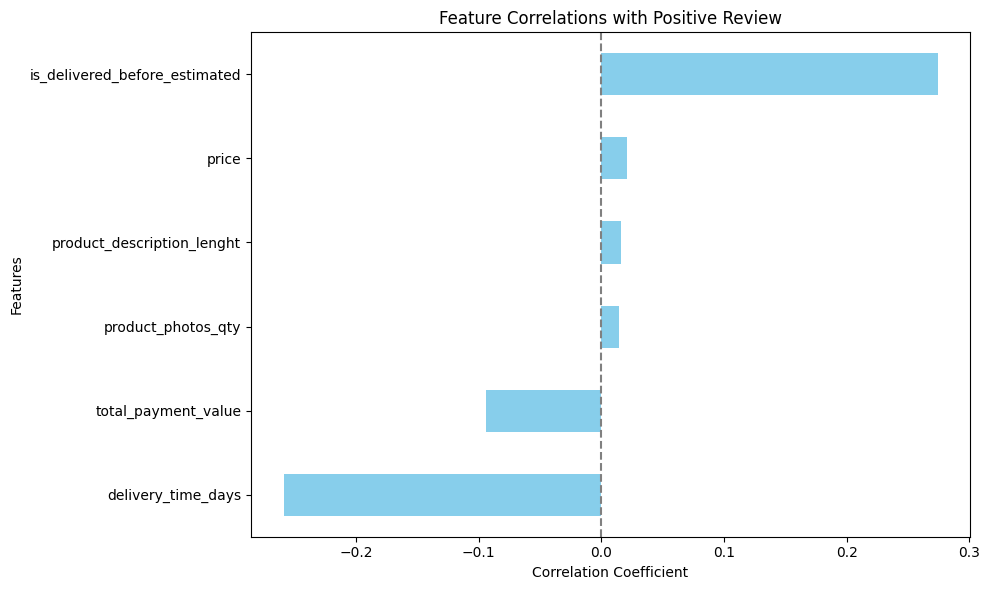

In [110]:
# Assuming `correlations` the correlation coefficients between features and the target variable
correlations = X_test.corrwith(y_test)

# Create a bar chart
plt.figure(figsize=(10, 6))
correlations.sort_values().plot(kind='barh', color='skyblue')
plt.title('Feature Correlations with Positive Review')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.axvline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()


##### Total Payment Value <br>
High payment customers ⮕ higher expectations <br>
Advice: Personalised services <br>

##### Delivered before Estimated Time <br>
Early delivery ⮕ enhances customer satisfaction <br>
Advice: Ensuring accurate delivery estimates / Delivered earlier <br>

##### Product Description Length <br>
Detailed information ⮕ reduces uncertainty <br>
Advice: Recommend optimizing product descriptions <br>